packages used

In [1]:
# !pip install pandas
# !pip install torch
# !pip install matplotlib
# !pip install "numpy<2"
# !pip install torch_geometric


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import functools
import re
from time import time
import numpy as np
import os
from sys import platform
if not os.path.exists("model.py"):
    !wget https://raw.githubusercontent.com/SomeoneNamedCaz/RNAFolding/refs/heads/main/model.py
from model import Model
from glob import glob
import sys

In [3]:
# hyperparameters
hiddenDim = 128
batch_size = 16
outputDim = 1 # one dist for each output TODO: try onehot outputs
learning_rate = 0.0001
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
DISTOGRAM_FILE_NAME = "distogram.pt"



cpu


# Preprocessing

In [4]:

# input processing

if platform == "linux" or platform == "linux2":
    DISTOGRAM_DIR = "/kaggle/input/distograms/distograms"
    inputDir = "/kaggle/input/"
elif platform == "darwin":
    inputDir = "."
    DISTOGRAM_DIR = "distograms"
trainSeqs = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/train_sequences.csv"))



nucs = functools.reduce(set.union,trainSeqs["sequence"].apply(list).map(set).to_list()) # get all unique nucs at all positions
nucs.add("NONE")
nucToIdx = {nuc: i for i, nuc in enumerate(nucs)}

def processSeqDF(inputSeqs,nucToIdx):
    indexSeqs = inputSeqs["sequence"].apply(list)
    indexSeqs = indexSeqs.apply(pd.Series).fillna("NONE")
    idxToKeep = torch.tensor((indexSeqs != 'NONE').to_numpy(int),dtype=int).unsqueeze(-1)



    indexSeqs = indexSeqs.map(lambda nuc: nucToIdx[nuc])
    indexSeqs.index = inputSeqs["target_id"]

    seqTensor = torch.tensor(indexSeqs.values, dtype=torch.int)
    return seqTensor, indexSeqs, idxToKeep

trainSeqTensor,_ , trainIdxToKeep = processSeqDF(trainSeqs, nucToIdx)

In [5]:
# output label processing

trainLabels = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/train_labels.csv"))
trainLabels["ID"] = trainLabels["ID"].map(lambda x: re.sub(r"_\d+$","",x))
pivotedLabels = trainLabels.pivot(index="ID",columns="resid",values=["x_1","y_1","z_1"])
pivotedLabels.fillna(0,inplace=True)
pivotedLabels.shape
labelTensor = torch.tensor(pivotedLabels.to_numpy().reshape(pivotedLabels.shape[0],3,-1)).transpose(1,2)


# labelTensor = labelTensor - torch.concat((torch.zeros_like(labelTensor[:,:1]), labelTensor[:,:-1]), dim=1)

def converToDistogramSlow(allData):
    """ coords tensor [residue number, coord index(0->x,1->y,2->z)]
            returns: tensor [residue number,residue number] # distances between two points
    """ 
    
    for entryIndex, coords in enumerate(allData):
        for resIdx, residue in enumerate(coords):
            # print(help(torch.linalg.vector_norm))
            distancesToResidue = torch.linalg.vector_norm(coords - residue, dim=-1).unsqueeze(0)
            if resIdx == 0:
                entryDistances = distancesToResidue
            else:
                entryDistances = torch.concat((entryDistances,distancesToResidue))
        entryDistances = entryDistances.unsqueeze(0)
        if entryIndex == 0:
            allDistances = entryDistances
        else:
            allDistances = torch.concat((allDistances,entryDistances))
        
    return allDistances

def convertToDistogramFast(coords):
    """ coords tensor [residue number, coord index(0->x,1->y,2->z)]
            returns: tensor [residue number,residue number] # distances between two points
    """   

    diff = coords[:,:,None] - coords[:,None,:]
    dists = torch.linalg.vector_norm(diff,dim=-1)
    dists = dists.half()
    return dists

assert (convertToDistogramFast(labelTensor[:10,:20]) == converToDistogramSlow(labelTensor[:10,:20]).half()).all()




In [6]:
def makeDistogramDir(path, seqTensor, idxToKeep, remakeAll=False):
    os.makedirs(path, exist_ok=True,)
    t0 = time()
    for i, _ in enumerate(labelTensor):
        
        savePath = os.path.join(path,re.sub(r"\.(\w+)$", str(i) + r".\1",DISTOGRAM_FILE_NAME))
        if not os.path.exists(savePath) or remakeAll:
            out = convertToDistogramFast(labelTensor[i].unsqueeze(-1))
            torch.save((seqTensor[i], idxToKeep[i], out), savePath)
    print("took",time()-t0,"to make distograms")
    

In [7]:
# makeDistogramDir(DISTOGRAM_DIR,trainSeqTensor, trainIdxToKeep, remakeAll=True)

In [8]:
print(trainSeqTensor.numel() * trainSeqTensor.element_size() / 1e6, "MB")
print(trainIdxToKeep.numel() * trainIdxToKeep.element_size() / 1e6, "MB")

14.510048 MB
29.020096 MB


In [9]:
class RNADataset(Dataset):
    def __init__(self, seqTensor, idxToKeep, distogramDir):
        super().__init__()
        self.distogramPaths = glob(os.path.join(distogramDir,"*"))
        self.seqTensor = seqTensor
        self.idxToKeep = idxToKeep
    def __len__(self):
        return len(self.distogramPaths)

    def __getitem__(self, idx):
        return torch.load(self.distogramPaths[idx]) 


In [10]:
# make data loader
train_dataset = RNADataset(trainSeqTensor, trainIdxToKeep, DISTOGRAM_DIR)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [11]:
## test input processing 
testSeqs = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/test_sequences.csv"))
testSeqTensor, indexSeqs, testIndexToKeep = processSeqDF(testSeqs, nucToIdx)
test_loader = DataLoader(list(zip(testSeqTensor,trainIdxToKeep, testIndexToKeep)), batch_size=2)

# model architecture and training

In [12]:
def plotRollingAvg(losses,window = 100):
    plt.plot(losses,alpha=0.5)
    
    plt.plot([sum(losses[i:i+window]) / len(losses[i:i+window])  for i in range(len(losses))],color="b")


In [ ]:
def train(model, opter, train_loader,numEpochs = 100,logFreq = 5):
    losses = []
    try:
        with open("trainingLog.txt", "a") as logFile:
            for epoch in range(numEpochs):
                for step, (batchSeqs, batchIdx, batchLabels) in enumerate(train_loader):
                    batchSeqs = batchSeqs.to(device)
                    batchLabels = batchLabels.to(device)
                    batchIdx = batchIdx.to(device)
                    opter.zero_grad()
                    
                    
                    seqLens = torch.sum(batchIdx,axis=1).squeeze()

                    maxLen = max(seqLens)
                    batchSeqs = batchSeqs[:,:maxLen]
                    batchIdx = batchIdx[:,:maxLen].unsqueeze(2)
                    print("index",batchIdx.shape)
                    batchLabels = batchLabels.transpose(1,-1) # TODO: remake dataset with this included and remove this line
                    batchLabels = batchLabels[:,:maxLen,:maxLen]
                    print("batch labels", batchLabels.shape)
                    # MSE that accounts for differing lengths. This makes short sequences have a similar error to long sequences and zeros out errors on non existant positions
                    mse = (batchLabels - model(batchSeqs)) ** 2

                    print("Outside: input size", batchSeqs.size(),"output_size", mse.size())
                    loss = torch.mean(torch.sum(mse * batchIdx,dim=(1,2,3)) / seqLens)
                    
                    losses.append(loss.item())
                    loss.backward()
                    opter.step()

                    if step % logFreq == 0:
                        print("epoch", epoch,"step", step, torch.mean(torch.tensor(losses[-logFreq:])), file=logFile,flush=True)
                        print("epoch", epoch,"step", step, torch.mean(torch.tensor(losses[-logFreq:])),flush=True)
                        torch.save(model, "model.pt")
    except KeyboardInterrupt:
        return losses
    # except:
    #     torch.save(model, "model.pt")
    return losses


In [ ]:
numDistinctInputs = len(nucs)
model = Model(numDistinctInputs, hiddenDim, outputDim, device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)
opter = torch.optim.Adam(model.parameters(),lr=learning_rate)
losses = train(model, opter, train_loader)


made model with 1253889 parameters of which 1253889 are trainable
index torch.Size([16, 354, 1, 1])
batch labels torch.Size([16, 354, 354, 1])


In [ ]:
# plotRollingAvg(losses)

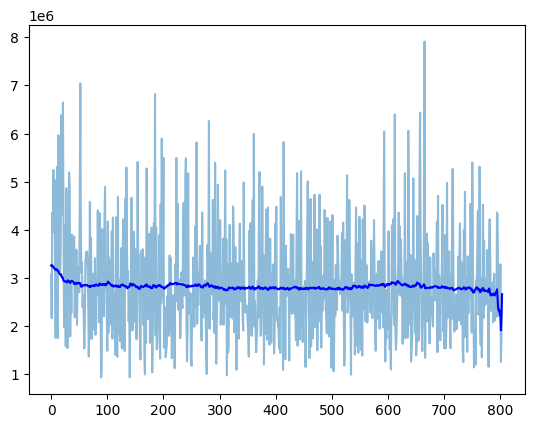

In [22]:
with open("/Users/cazcullimore/Downloads/trainingLog.txt") as file:
    data = "".join(file.readlines())
    floatLosses = [float(elt) for elt in re.findall(r"\((\d+\.\d*)\)",data)]
    plotRollingAvg(floatLosses)